# Parameter Calibration & Classification using the Hessian Matrix

This file provides example usage for calibrating some unknown parameters and classifying the optimisation result. The result is analysed using the eigenvectors of the Hessian matrix of the cost function with respect to the parameters evaluated at the optimal point.

### Setting up the Environment

If you don't already have PyBOP installed, check out the [installation guide](https://pybop-docs.readthedocs.io/en/latest/installation.html) first.

We begin by importing the necessary libraries. Let's also fix the random seed to generate consistent output during development.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pybamm

import pybop

np.random.seed(8)  # users can remove this line

Create a reference dataset for the calibration process. We use a physics-based model to generate synthetic data. This can be replaced with actual experimental data.

In [ ]:
model = pybamm.lithium_ion.SPMe()
parameter_values = pybamm.ParameterValues("Chen2020")
pulse_time = 3500
initial_soc = 1.0
C_rate = 1  # 1C discharge rate
experiment = pybamm.Experiment(
    [f"Discharge at {C_rate}C for {pulse_time} seconds"],
    period="10 seconds",
)
sim = pybamm.Simulation(model, parameter_values=parameter_values, experiment=experiment)
solution = sim.solve(initial_soc=initial_soc)

# Extract voltage, current, time from the solution
dataset = pybop.Dataset(
    {
        "Time [s]": solution.t,
        "Current function [A]": solution["Current [A]"].entries,
        "Voltage [V]": solution["Terminal voltage [V]"].entries,
    }
)

Next, we define the parameters for optimisation. We assume the negative and positive particle diffusivity are unknown and try to find them using the optimisation process.

In [ ]:
parameter_values = pybamm.ParameterValues("Chen2020")
parameter_values.update(
    {
        "Negative particle diffusivity [m2.s-1]": pybop.Parameter(
            bounds=[1e-15, 1e-11],
            initial_value=1.68e-12,  # actual value: 3.3e-14
        ),
        "Positive particle diffusivity [m2.s-1]": pybop.Parameter(
            bounds=[1e-17, 1e-13],
            initial_value=1.32e-16,  # actual value: 4e-15
        ),
    }
)

Here, we set up the simulator, cost, and problem class.

In [ ]:
parameter_values.set_initial_state(initial_soc)
simulator = pybop.pybamm.Simulator(
    model, parameter_values=parameter_values, protocol=dataset
)
cost = pybop.SumSquaredError(dataset)
problem = pybop.Problem(simulator, cost)

Set up the optimiser and run it.

In [ ]:
options = pybop.SciPyDifferentialEvolutionOptions(maxiter=35, popsize=7)
optim = pybop.SciPyDifferentialEvolution(problem, options=options)
result = optim.run()
print(result)

OptimisationResult:
  Best result from 1 run(s).
  Initial parameters: [4.82972820e-12 2.43100795e-14]
  Optimised parameters: [3.30183251e-14 3.99643400e-15]
  Best cost: 1.2946770011814918e-06
  Optimisation time: 4.448797702789307 seconds
  Number of iterations: 35
  Number of evaluations: 508
  Reason for stopping: Maximum number of iterations has been exceeded.


Confirm that the optimiser has located a minimum, by classifying the result using the finite-difference Hessian.

In [ ]:
info = pybop.classify_using_hessian(result, normalise=True)

The optimiser has located a minimum.


## Plotting and visualisation

Compare the ground truth vs. the optimised result.

In [ ]:
pybop.plot.problem(problem, inputs=result.best_inputs, title="Optimised Comparison");

Visualise the cost landscape.

In [ ]:
pybop.plot.surface(result)

The eigenvectors of the Hessian matrix evaluated at the optimal point tell us about any so-called "stiff" and "sloppy" directions. The Hessian matrix is evaluated numerically using finite difference approximations.

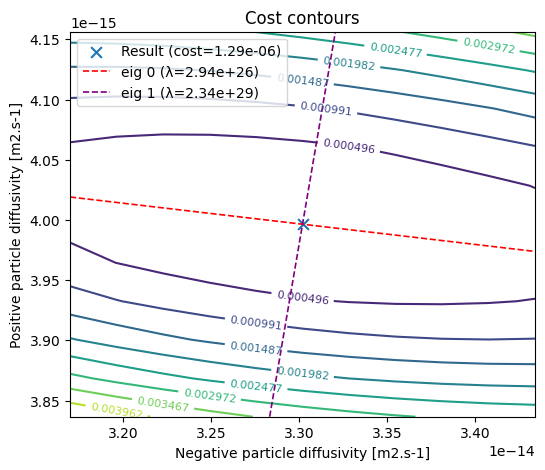

In [ ]:
fig, ax = pybop.plot_hessian_eigenvectors(info, steps=11)
plt.show()

## Concluding thoughts

In this example, we analyse the optimisation result to show that a minimum has been located. The finite-difference Hessian is used to identify parameter correlations.